# Feature Selection

In this practical, you will become familiarized with some basic feature selection methods implemented in scikit-learn. Consider the prostate dataset that is attached to this practical. You are asked to:

1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.

2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.

3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.

4. What feature selection method performs best? Can you explain why?

Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:

1. Estimate the performance of the nearest neighbor classifier with K=3 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.

2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.
3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.

4. By taking a look at these results, what is the optimal number of features to use in this dataset?

5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features. 

In [20]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns; sns.set()
import scipy.stats as stats
import scipy as sp
from scipy import linalg
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, precision_score

## Methods

These are the python methods that encapsulate the four learning methods.

### Implementation details

**Quadratic Discriminant Analysis**

Before training the classifier we have chosen a good value for the corresponding regularization hyper-parameter with a grid-search guided by cross-validation.

The regularization parameter regularizes the covariance matrix estimate as $$(1-\lambda)\cdot \mathbf{\Sigma} + \lambda \cdot \mathbf{I}$$

**Nearest Centroids**

Before training the classifier we have chosen a good value for the shrinkage threshold hyper-parameter with a grid-search guided by cross-validation.

This procedure leads to a reduction in the number of features, by zeroing all deltas that exceed the threshold.

They take the form: 
$$\mu_{kj} = m_j + \Delta_{kj}\,,$$ 
where $\Delta_{kj}$ is the shrunken component


**Selecting the best parameter value**

To do so, as a first idea, we compute the set of values with the maximum test data accuracy, and between then we choose the set of values that have the maximum train data accuracy. From this set we choose the lowest value.

We compare this method defined in the global parameter *gp_best_hyper_method = "max_in_test"* to the method than simply computes the parameter for maximum cross validation data accuracy (*gp_best_hyper_method = "max_in_cv"*) and we obtain better accuracies in test data. But we came into account that because we use test data to adjust the hyper-parameter perhaps we are introducing some bias  improving the accuracy of this particular test data, and so a optimistic evaluation of the accuracy.

Thus, we compute the hyperparameters with "max_in_cv" choose method.


In [4]:
# Global parameters
# Verbose flag
gp_verbose = False
# Show progress  flag
gp_show_progress = True
# Disable plots
gp_disable_plots = True
# Activate QDA with hyper-parameter reg_param
gp_qda_hyper = True
# Activate NSC with hyper-parameter shrink_threshold
gp_nsc_hyper = True
# Dimensionality reduction(PCA)
gp_dim_red = False
# Retained variance (PCA)
gp_retained_variance = 99
# Number of iterations
gp_iterations = 1
# Test size = number of samples / gp_test_size
gp_test_size = 3
# Best_hyper_param_method
gp_best_hyper_method = "max_in_cv"
# Skfold splits for hyperparameter guessing
gp_skfold_splits = 10

# Global execution parameters
# New dimensions after PCA
ge_features_reduction = 0

#Number of params of learning methods
ge_complexity = []

# Methods
def get_component_number(df_data, desired_variance=99.0, scaling=False):
    """ 
    Obtain the number of components that explains a %desired_variance
    Args:
        df_data (dataframe): dataframe of features in cols and samples in rows
        desired_variance (float): desired explained variance
        scaling (boolean): True if pre-scaling is needed prior to compute PCA
    Returns:
        int: number of components to maintain to have a explained variance >= desired_variance
        float: variance explained for the nunber of components returned
        numpy array: cumulative variance by number of components retained
    """  
    if scaling:
        df_data_2 = preprocessing.StandardScaler().fit_transform(df_data)
    else:
        df_data_2 = df_data
    # project the data into this new PCA space
    pca = PCA().fit(df_data_2)
    desired_variance = desired_variance/100.0
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    component_number = 0
    for cumulative_variance in explained_variance:
        component_number += 1
        if cumulative_variance >= desired_variance:
            break
    return component_number, cumulative_variance, explained_variance


def create_datasets_from_file(data_file, header, random_state, label_pos, 
                              label_value, features_ini, features_fin=None,
                              with_dim_red=False, retained_variance=99.0,
                              reuse=False, dataset=None, labels=None):
    """Create training and test sets from file

        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file.
            with_dim_red (bool): If True, it performs a dimensionality reduction by PCA
            retained_variance (float): If dimensionality reduction, variance to retain
            reuse (bool): Reuse previous dataset
            dataset: Dataset to reuse
            labels: Labels to reuse

        Returns:
            (np.array): train set scaled
            (np.array): test set scaled
            (np.array): class labels for the train set
            (np.array): class labels for the test set
            (np.array): dataset
            (np.array): labels
                
    """
    global ge_features_reduction
    if not reuse:
        data = pd.read_csv(data_file, header = header)
        if features_fin == None:
            X = data.values[ :, features_ini:].astype(np.float)
        else:
            X = data.values[ :, features_ini:features_fin].astype(np.float)
        y = (data.values[ :, label_pos ] == label_value).astype(np.int)
    else: #reuse previous dataset
        X = dataset
        y = labels
    
    # Split dataset between training and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=1.0/gp_test_size, random_state=random_state)
    # Data standardization
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    # Check standardization
    for i in range (1, np.size(x_train_scaled,1)):
        assert round(np.var(x_train_scaled[:,0]),3) == round(np.var(x_train_scaled[:,i]),3),\
        "Warning: revise data standardization"
        
    if with_dim_red:
        desired_variance = retained_variance
        component_number, _, _ =\
            get_component_number(x_train_scaled, desired_variance, scaling=None)
        if gp_verbose: print("Features reduced to", component_number)
        ge_features_reduction = component_number
        pca = PCA(n_components = component_number)
        pca.fit(x_train_scaled)
        x_train_scaled = pca.transform(x_train_scaled)
        x_test_scaled = pca.transform(x_test_scaled)
        
    return x_train_scaled, x_test_scaled, y_train, y_test, X, y

def prediction_accuracy(x_train, x_test, y_train, y_test, method_func, method_param="", param_value=""):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            method_param (string): name of learning method parameter
            param_value (float): value of parameter to try
        Returns:
            float: best parameter value to use in prediction
                
    """
    if method_param != "" :
        params = {method_param : param_value}
    else:
        params ={}
    method = globals()[method_func](**params)
    
    # Training
    method.fit(x_train, y_train)

    ge_complexity.append([method_func, len(method.get_params())])
    # Prediction of test
    y_pred = method.predict(x_test)
    conf_test = confusion_matrix(y_test, y_pred, labels=[1,0])
    
    # Prediction of train
    y_pred = method.predict(x_train)
    conf_train = confusion_matrix(y_train, y_pred, labels=[1,0])
    
    return conf_train, conf_test

def estimate_parameter(x_train, x_test, y_train, y_test, 
                       method_func, param, param_values,
                       best_param_value_method="max_in_test"):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            param (string): name of learning method parameter
            param_values (list of float): list of parameter values to try
            best_param_value_method: if "max_in_test" gives the value with the maximum accuracy
                                     in test data.
        Returns:
            (float): best parameter value to use in prediction
                
    """
    # Pipeline for estimate the regularization parameter
    pipeline = Pipeline([ ('method', globals()[method_func]()) ])

    # Construct the grid the hyperparameter candidate shronk theshold
    param_grid = { 'method__' + param : param_values }

    # Evaluating 
    skfold = RepeatedStratifiedKFold(n_splits=gp_skfold_splits, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid,\
            scoring=make_scorer(accuracy_score))
    result = gridcv.fit(x_train, y_train)

    # Accuracies
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']

    test_accuracies = np.ones(len(param_values))
   
    for i in range(len(param_values)):
        method_params = {param : param_values[ i ]}
        method = globals()[method_func](**method_params)
        method.fit(x_train, y_train)
        test_accuracies[ i ] = accuracy_score(method.predict(x_test), y_test)
    
    # Obtain best_param_value as max 
    max_test_accuracy = max(test_accuracies)
    if best_param_value_method == "max_in_test":
        best_param_value = 0
        best_train_accuracy = 0
        for i in range(len(param_values)):
            if test_accuracies[ i ] == max_test_accuracy:
                if accuracies[i] > best_train_accuracy:
                    best_train_accuracy = accuracies[i]
                    best_param_value = param_values[i]
    else:
        best_param_value = param_values[ np.argmax(accuracies) ]
    # Plot
    if not gp_disable_plots:
        plt.figure(figsize=(9, 9))
        line1, = plt.plot(param_values, accuracies, 'o-', color="g")
        line2, = plt.plot(param_values, test_accuracies, 'x-', color="r")
        plt.fill_between(param_values, accuracies - std_accuracies / np.sqrt(10), \
            accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
        plt.grid()
        plt.title("Different hyper-parameter " + param + " values for " + method_func)
        plt.xlabel('Hyper-parameter')
        plt.xticks(np.round(np.array(param_values), 2))
        plt.ylabel('Classification Accuracy')
        plt.ylim((min(min(accuracies), min(test_accuracies)) - 0.1, 
                  min(1.02, max(max(accuracies), max(test_accuracies))  + 0.1)))

        plt.xlim((min(param_values), max(param_values)))
        legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                                  markersize=15, label='CV-estimate'), \
                        mlines.Line2D([], [], color='r', marker='x', \
                                  markersize=15, label='Test set estimate')]
        plt.legend(handles=legend_handles, loc = 3)
        plt.show()
    if gp_verbose:
        print("Best param value %s Method %s: %s" % (method_func, best_param_value_method, best_param_value))
    return best_param_value

def calculate_avg_results(train_results, test_results, classifier_name):
    """Calculate the average accuracy, TPN and TNR for the n=gp_iterations of a classifier
        Args:
            train_results (array nx2x2): Each of the n confusions matrix generated for the train set
            test_results (array nx2x2): Each of the n confusions matrix generated for the test set
            classifier_name (string): Classifier name gp_iterations print the results
        Returns:
            (np.array 3): Average accuracy, TPR and TNR of the n iterations of the train set
            (np.array 3): Average accuracy, TPR and TNR of the n iterations of the test set
            (np.array 3): Stdev accuracy, TPR and TNR of the n iterations of the train set
            (np.array 3): Stdev accuracy, TPR and TNR of the n iterations of the test set
            
    """
    
    measures_train = np.zeros(shape = (gp_iterations,3)) # Each row is an ex. and each column is the accuracy, TPR and TNR
    measures_test = np.zeros(shape =(gp_iterations,3))
    
    avg_results_train = np.zeros(3) # Each element is the average accuracy, the TPR and the TNR
    avg_results_test = np.zeros(3)
    #   TP in 0,0
    #   FN in 0,1 
    #   TN in 1,1
    #   FP in 1,0
    for i in range(gp_iterations):
        # For train set
        TN = train_results[i,1,1]
        TP = train_results[i,0,0]        
        FP = train_results[i,1,0]
        FN = train_results[i,0,1]
        measures_train[i][0] = (TP + TN) / (TN + TP + FP + FN)
        measures_train[i][1] = (TP / (TP + FN))
        measures_train[i][2] = (TN / (TN + FP))
        
        #For the test set
        TN = test_results[i,1,1]
        TP = test_results[i,0,0]
        FP = test_results[i,1,0]
        FN = test_results[i,0,1]
        measures_test[i][0] = (TP + TN) / (TN + TP + FP + FN)
        measures_test[i][1] = (TP / (TP + FN))
        measures_test[i][2] = (TN / (TN + FP))
    
    avg_results_train = measures_train.mean(axis = 0)
    avg_results_test = measures_test.mean(axis = 0)
    std_results_train = measures_train.std(axis = 0)
    std_results_test = measures_test.std(axis = 0)
    if gp_verbose:
        print("\nResults for the ", classifier_name, " classifier\n")

        print('For the train set:')
        print('Predicion accuracy of train set is: %f' % avg_results_train[0])
        print('True postive rate of train set is: %f' % avg_results_train[1])
        print('True negative rate of train set is: %f\n' % avg_results_train[2])

        print('For the test set:')
        print('Predicion accuracy of train set is: %f' % avg_results_test[0])
        print('True postive rate of train set is: %f' % avg_results_test[1])
        print('True negative rate of train set is: %f\n' % avg_results_test[2])

    return avg_results_train, avg_results_test, std_results_train, std_results_test

def print_parameters():
    print("Parameters")
    params = []
    names = []
    for method in gp_hyper.keys:
         params.add[]
    pdata = {'Parameters' : [gp_qda_hyper, gp_nsc_hyper,
                             gp_dim_red, gp_retained_variance, 
                             gp_iterations, 100.0/gp_test_size,
                             gp_best_hyper_method]}
    pdataf = pd.DataFrame(data = pdata, index = ['QDA hyper-parameter reg_param',
                                                 'NSC Hyper-parameter shrink_threshold',
                                                 'Dimensionality Reduction', 
                                                 'Retained variance',
                                                 'Number of iterations',
                                                 'Test set size',
                                                 'Best hyperparameter select method'])
    display(pdataf)
    print("")
    
def print_execution_data():
    print("Execution data")
    data = [ge_samples, ge_features, ge_features_reduction]
    index = ['Number of samples', 'Number of features', 'Features reduction']
    for [method, complexity] in ge_complexity:
        data.append(complexity)
        index.append("Params " + method)
    pdata = {'Execution Data' : data}
    pdataf = pd.DataFrame(data = pdata, index = index)
    display(pdataf)
    print("")
    
def print_accuracies_old(accuracy_NBC, accuracy_LDA, accuracy_QDA, accuracy_NSC, metric):
    print(metric)
    d = {}
    for m in [accuracy_NBC, accuracy_LDA, accuracy_QDA, accuracy_NSC]:
        overfit_indicator = 1000 * round(abs(m[1] - m[0]) / (m[0] + 0.0000001), 4)
        #overfit_indicator = round(abs(m[1] - m[0]),3)
        m[0] = (round(m[0],2), round(m[2],2))
        m[1] = (round(m[1],2), round(m[3],2))
        m[2] = overfit_indicator
    d = {'NBC': accuracy_NBC[:3],
         'LDA': accuracy_LDA[:3], 
         'QDA': accuracy_QDA[:3],
         'NSC': accuracy_NSC[:3]}
    df = pd.DataFrame(data = d, index = ['Train', 'Test', 'Overfit degree'])
    display(df)
    print("")

def learn_dataset_old(data_file, header, random_state, label_pos, 
                  label_value, features_ini, features_fin=None,
                  best_param_value_method="max_in_test",
                  with_dim_red=False, retained_variance=99.0):
    """Learn data sets from file, methods:
            1. The Naive Bayes Classifier
            2. LDA
            3. QDA
            4. Nearest Shrunken Centroids Classifier
        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split of sets (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value. We consider this label as
            the positive label in prediction validation. We asign malign or cancer status to this label.
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file
            best_param_value_method (str): if "max_in_test" gives the value with the maximum accuracy
                                     in test data
            with_dim_red (bool): If True, it performs a dimensionality reduction by PCA
            retained_variance (float): If dimensionality reduction, variance to retain
                
    """
    global ge_features_reduction
    global ge_features
    global ge_samples
    global ge_complexity
    ge_features_reduction = 0
    nbc_train = np.zeros(shape=(gp_iterations,2,2))
    nbc_test = np.zeros(shape=(gp_iterations,2,2))
    lda_train = np.zeros(shape=(gp_iterations,2,2))
    lda_test = np.zeros(shape=(gp_iterations,2,2))
    qda_train = np.zeros(shape=(gp_iterations,2,2))
    qda_test = np.zeros(shape=(gp_iterations,2,2))
    nsc_train = np.zeros(shape=(gp_iterations,2,2))
    nsc_test = np.zeros(shape=(gp_iterations,2,2))

    
    for i in range(gp_iterations):
        ge_complexity = []
        if gp_show_progress: print("\nIteration: ",i)
        if i == 0: 
            reuse = False
            X = None
            y = None
        else:
            reuse = True
        X_train_scaled, X_test_scaled, y_train, y_test, X, y = \
            create_datasets_from_file(data_file, header, random_state + i, 
                                      label_pos, label_value, features_ini, features_fin = features_fin,
                                      with_dim_red = with_dim_red, retained_variance = retained_variance,
                                      reuse = reuse, dataset = X, labels = y)
        ge_samples = X.shape[0]
        ge_features = X.shape[1]
        if gp_verbose: print(X_train_scaled.shape)

        if gp_verbose: print("NBC")
        # Naive Bayes accuracy
        nbc_train[i], nbc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB")

        # LDA accuracy
        if gp_verbose: print("LDA")
        lda_train[i], lda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "LinearDiscriminantAnalysis")

        # QDA estimate reg parameter
        if gp_verbose: print("QDA")
        if gp_qda_hyper:
            param_values = np.linspace(0, 1, 10).tolist()
            best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                               "QuadraticDiscriminantAnalysis", "reg_param", param_values,\
                                best_param_value_method)
            # QDA accuracy
            # Best parameter reg value according CV estimate
            qda_train[i], qda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                "QuadraticDiscriminantAnalysis", "reg_param", best_param_value)
        else:
            qda_train[i], qda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                "QuadraticDiscriminantAnalysis")
        # Centroids
        if gp_verbose: print("NSC")
        if gp_nsc_hyper:
            # Best parameter shrink_threshold value according CV estimate
            param_values = np.linspace(0, 8, 20).tolist()
            best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                               "NearestCentroid", "shrink_threshold", param_values,\
                                best_param_value_method)
            # Centroids accuracy
            nsc_train[i], nsc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                               "NearestCentroid", "shrink_threshold", best_param_value)
        else:
            nsc_train[i], nsc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                               "NearestCentroid")
    # Calculate and print the average results
    avg_results_train_NBC, avg_results_test_NBC, std_results_train_NBC, std_results_test_NBC = calculate_avg_results(nbc_train, nbc_test, "NBC")
    avg_results_train_LDA, avg_results_test_LDA, std_results_train_LDA, std_results_test_LDA = calculate_avg_results(lda_train, lda_test, "LDA")
    avg_results_train_QDA, avg_results_test_QDA, std_results_train_QDA, std_results_test_QDA = calculate_avg_results(qda_train, qda_test, "QDA")
    avg_results_train_NSC, avg_results_test_NSC, std_results_train_NSC, std_results_test_NSC = calculate_avg_results(nsc_train, nsc_test,"NSC")
    
    print_parameters()
    i = 0
    for metric in ["Accuracy", "TPR", "TNR"]:
        print_accuracies_old([avg_results_train_NBC[i], avg_results_test_NBC[i], std_results_train_NBC[i], std_results_test_NBC[i]],
                     [avg_results_train_LDA[i], avg_results_test_LDA[i], std_results_train_LDA[i], std_results_test_LDA[i]],
                     [avg_results_train_QDA[i], avg_results_test_QDA[i], std_results_train_QDA[i], std_results_test_QDA[i]],
                     [avg_results_train_NSC[i], avg_results_test_NSC[i], std_results_train_NSC[i], std_results_test_NSC[i]], metric)
        i += 1
    print_execution_data()           

In [34]:
gp_functions = { 'NBC' : 'GaussianNB', 'LDA' : 'LinearDiscriminantAnalysis',
                 'QDA' : 'QuadraticDiscriminantAnalysis', 'NSC' : 'NearestCentroid'}

gp_hyper = {'QDA' : True, 'NSC' : True}

gp_params = {'QDA' : 'reg_param', 'NSC' : 'shrink_threshold'}

gp_param_values = {'QDA' : np.linspace(0, 1, 10).tolist(),
                   'NSC' : np.linspace(0, 8, 20).tolist()}

gp_metrics = ["Accuracy", "TPR", "TNR"]

def print_accuracies(avg_results, std_results, metric):
    print(metric)
    metric_idx = gp_metrics.index(metric)
    d = {}
    methods = list(avg_results.keys())
    for method in methods:
        m = [avg_results[method]['train'][metric_idx],  avg_results[method]['test'][metric_idx],
             std_results[method]['train'][metric_idx],  std_results[method]['test'][metric_idx]]
        overfit_indicator = 1000 * round(abs(m[1] - m[0]) / (m[0] + 0.0000001), 4)
        #overfit_indicator = round(abs(m[1] - m[0]),3)
        m[0] = (round(m[0],2), round(m[2],2))
        m[1] = (round(m[1],2), round(m[3],2))
        m[2] = overfit_indicator
        d[method] = m[:3]
    df = pd.DataFrame(data = d, index = ['Train', 'Test', 'Overfit degree'])
    display(df)
    print("")
                   
def learn_dataset(data_file, header, random_state, label_pos, 
                  label_value, features_ini, features_fin=None,
                  methods=['NBC', 'LDA', 'QDA', 'NSC'],
                  best_param_value_method="max_in_test",
                  with_dim_red=False, retained_variance=99.0):
    """Learn data sets from file, methods:
            1. The Naive Bayes Classifier
            2. LDA
            3. QDA
            4. Nearest Shrunken Centroids Classifier
        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split of sets (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value. We consider this label as
            the positive label in prediction validation. We asign malign or cancer status to this label.
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file
            methods (list of str): Learning methods to submit
            best_param_value_method (str): if "max_in_test" gives the value with the maximum accuracy
                                     in test data
            with_dim_red (bool): If True, it performs a dimensionality reduction by PCA
            retained_variance (float): If dimensionality reduction, variance to retain
                
    """
    global ge_features_reduction
    global ge_features
    global ge_samples
    global ge_complexity
    ge_features_reduction = 0
    conf_matrix = {}
    for method in methods:
        conf_matrix[method] = {}
        conf_matrix[method]['train'] = np.zeros(shape=(gp_iterations,2,2))
        conf_matrix[method]['test'] = np.zeros(shape=(gp_iterations,2,2))
    
    for i in range(gp_iterations):
        ge_complexity = []
        if gp_show_progress: print("\nIteration: ",i)
        if i == 0: 
            reuse = False
            X = None
            y = None
        else:
            reuse = True
        X_train_scaled, X_test_scaled, y_train, y_test, X, y = \
            create_datasets_from_file(data_file, header, random_state + i, 
                                      label_pos, label_value, features_ini, features_fin = features_fin,
                                      with_dim_red = with_dim_red, retained_variance = retained_variance,
                                      reuse = reuse, dataset = X, labels = y)
        ge_samples = X.shape[0]
        ge_features = X.shape[1]
        if gp_verbose: print(X_train_scaled.shape)
        
        for method in methods:
            if gp_verbose: print(method)
            if method in ['NBC', 'LDA']:
                conf_matrix[method]['train'][i], conf_matrix[method]['test'][i] =\
                    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, gp_functions[method])
                
            if method in ['QDA', 'NSC']:
                if gp_hyper[method]:
                    best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                                    gp_functions[method], gp_params[method], gp_param_values[method],\
                                    best_param_value_method)
                    conf_matrix[method]['train'][i], conf_matrix[method]['test'][i] =\
                        prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                    gp_functions[method], gp_params[method], best_param_value)
                else:
                    conf_matrix[method]['train'][i], conf_matrix[method]['test'][i] =\
                    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                     gp_functions[method])
       
    # Calculate and print the average results
    avg_results = {}
    std_results = {}
    for method in methods:
        avg_results[method] = {'train' : None, 'test' : None}
        std_results[method] = {'train' : None, 'test' : None}
        avg_results[method]['train'], avg_results[method]['test'], std_results[method]['train'], std_results[method]['test'] =\
            calculate_avg_results(conf_matrix[method]['train'], conf_matrix[method]['test'], method)
    print_parameters()
    i = 0
    for metric in gp_metrics:
        print_accuracies(avg_results, std_results, metric)
        i += 1
    print_execution_data()           

## Breast cancer

In [35]:
gp_disable_plots = True
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 1
gp_show_progress = False
gp_best_hyper_method = "max_in_cv"
gp_skfold_splits = 10

learn_dataset(data_file = 'wdbc.csv', header = None, random_state=0, 
              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

#gp_dim_red = True
#learn_dataset(data_file = 'wdbc.csv', header = None, random_state=0, 
#              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
#              best_param_value_method = gp_best_hyper_method,
#              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,1
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,"(0.95, 0.0)","(0.96, 0.0)","(0.98, 0.0)","(0.94, 0.0)"
Test,"(0.9, 0.0)","(0.97, 0.0)","(0.96, 0.0)","(0.92, 0.0)"
Overfit degree,49.9,11,18.8,27.8



TPR


,NBC,LDA,QDA,NSC
Train,"(0.9, 0.0)","(0.91, 0.0)","(0.94, 0.0)","(0.89, 0.0)"
Test,"(0.85, 0.0)","(0.93, 0.0)","(0.91, 0.0)","(0.85, 0.0)"
Overfit degree,55.2,18.4,34.6,40.4



TNR


,NBC,LDA,QDA,NSC
Train,"(0.97, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.97, 0.0)"
Test,"(0.93, 0.0)","(1.0, 0.0)","(0.98, 0.0)","(0.95, 0.0)"
Overfit degree,49.5,4.3,12.2,24.3



Execution data


,Execution Data
Number of samples,569
Number of features,30
Features reduction,0
Params GaussianNB,2
Params LinearDiscriminantAnalysis,6
Params QuadraticDiscriminantAnalysis,5
Params NearestCentroid,2


### Hyper-parameter guessing plots

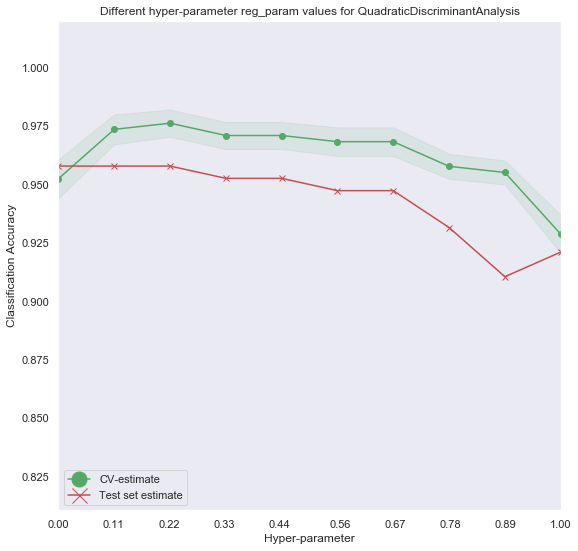

KeyError: 'train'

In [22]:
gp_disable_plots = False
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 1
gp_show_progress = False
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0

learn_dataset(data_file = 'wdbc.csv', header = None, random_state=0, 
              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance, 
              methods = ['QDA'])

## Prostate cancer

In [318]:
# Prostate Cancer
gp_disable_plots = True
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 20
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0
gp_skfold_splits = 5

learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

gp_best_hyper_method = "max_in_cv"
gp_dim_red = True
gp_retained_variance = 99
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

gp_best_hyper_method = "max_in_cv"
gp_dim_red = True
gp_retained_variance = 80
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,"(0.72, 0.06)","(0.86, 0.02)","(0.14, 0.25)","(0.91, 0.02)"
Test,"(0.64, 0.12)","(0.85, 0.04)","(0.64, 0.1)","(0.89, 0.05)"
Overfit degree,106.3,17.9,3557.9,26.5



TPR


,NBC,LDA,QDA,NSC
Train,"(0.68, 0.07)","(0.83, 0.03)","(0.12, 0.24)","(0.88, 0.03)"
Test,"(0.66, 0.12)","(0.8, 0.07)","(0.62, 0.18)","(0.85, 0.07)"
Overfit degree,29.6,36.8,4243.1,26.7



TNR


,NBC,LDA,QDA,NSC
Train,"(0.76, 0.08)","(0.89, 0.03)","(0.16, 0.27)","(0.95, 0.03)"
Test,"(0.62, 0.18)","(0.9, 0.08)","(0.63, 0.23)","(0.93, 0.06)"
Overfit degree,178.1,16.7,2863.6,19.8



Execution data


,Execution Data
Number of samples,102
Number of features,12625
Features reduction,0
Params GaussianNB,2
Params LinearDiscriminantAnalysis,6
Params QuadraticDiscriminantAnalysis,5
Params NearestCentroid,2



Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,"(0.92, 0.04)","(1.0, 0.0)","(0.87, 0.15)","(0.75, 0.08)"
Test,"(0.74, 0.12)","(0.9, 0.04)","(0.71, 0.09)","(0.72, 0.11)"
Overfit degree,200.6,100,181.1,41.3



TPR


,NBC,LDA,QDA,NSC
Train,"(0.92, 0.05)","(1.0, 0.0)","(0.83, 0.19)","(0.75, 0.08)"
Test,"(0.95, 0.05)","(0.87, 0.07)","(0.71, 0.14)","(0.73, 0.12)"
Overfit degree,40.9,128.7,140.4,22.2



TNR


,NBC,LDA,QDA,NSC
Train,"(0.93, 0.05)","(1.0, 0.0)","(0.92, 0.13)","(0.74, 0.1)"
Test,"(0.48, 0.29)","(0.93, 0.07)","(0.7, 0.19)","(0.69, 0.17)"
Overfit degree,483.8,66.9,235.8,62.9



Execution data


,Execution Data
Number of samples,102
Number of features,12625
Features reduction,63
Params GaussianNB,2
Params LinearDiscriminantAnalysis,6
Params QuadraticDiscriminantAnalysis,5
Params NearestCentroid,2



Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,80
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,"(0.89, 0.06)","(0.96, 0.02)","(0.98, 0.01)","(0.72, 0.08)"
Test,"(0.78, 0.08)","(0.85, 0.05)","(0.87, 0.05)","(0.67, 0.12)"
Overfit degree,116.8,110.6,116.8,76.3



TPR


,NBC,LDA,QDA,NSC
Train,"(0.83, 0.1)","(0.93, 0.04)","(0.97, 0.02)","(0.7, 0.09)"
Test,"(0.66, 0.13)","(0.82, 0.07)","(0.88, 0.07)","(0.69, 0.12)"
Overfit degree,200.4,122.7,91.3,11.2



TNR


,NBC,LDA,QDA,NSC
Train,"(0.94, 0.03)","(0.98, 0.02)","(0.99, 0.01)","(0.75, 0.08)"
Test,"(0.93, 0.07)","(0.9, 0.1)","(0.86, 0.11)","(0.64, 0.2)"
Overfit degree,15.2,82.4,133.7,137.2



Execution data


,Execution Data
Number of samples,102
Number of features,12625
Features reduction,19
Params GaussianNB,2
Params LinearDiscriminantAnalysis,6
Params QuadraticDiscriminantAnalysis,5
Params NearestCentroid,2


### Hyper-parameter guessing plots

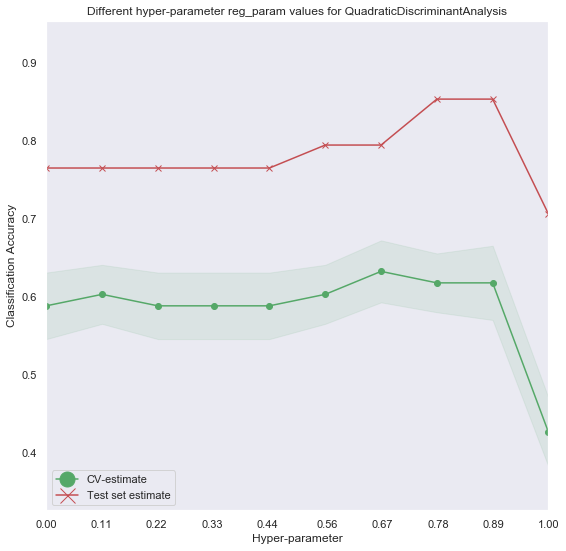

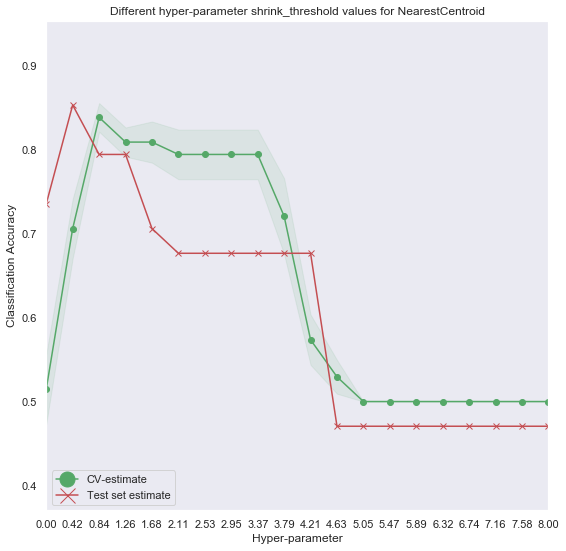

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,99
Number of iterations,1
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,"(0.94, 0.0)","(1.0, 0.0)","(0.93, 0.0)","(0.85, 0.0)"
Test,"(0.82, 0.0)","(0.91, 0.0)","(0.79, 0.0)","(0.79, 0.0)"
Overfit degree,125,88.2,142.9,69



TPR


,NBC,LDA,QDA,NSC
Train,"(0.97, 0.0)","(1.0, 0.0)","(0.91, 0.0)","(0.85, 0.0)"
Test,"(0.94, 0.0)","(0.83, 0.0)","(0.94, 0.0)","(0.72, 0.0)"
Overfit degree,26.9,166.7,35.8,153.3



TNR


,NBC,LDA,QDA,NSC
Train,"(0.91, 0.0)","(1.0, 0.0)","(0.94, 0.0)","(0.85, 0.0)"
Test,"(0.69, 0.0)","(1.0, 0.0)","(0.62, 0.0)","(0.88, 0.0)"
Overfit degree,246,0,335.9,25.9



Execution data


,Execution Data
Number of samples,102
Number of features,12625
Features reduction,63
Params GaussianNB,2
Params LinearDiscriminantAnalysis,6
Params QuadraticDiscriminantAnalysis,5
Params NearestCentroid,2


In [320]:
gp_disable_plots = False
gp_verbose = False
gp_dim_red = True
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 1
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0
gp_skfold_splits = 5
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

## Conclusions

**Executions**

We have two executions in breast, one without PCA and another with PCA (99 percent variance retained), and three in prostate, without PCA, with PCA 99 percent variance retention and PCA 80 percent variance. There is a parameter that indicates the level of possible overfit. The more his value, less robust to overfiting is the learning method, thus more flexible as more closed to the training data.

We have defined this *overfiting indicator* as the ratio of the difference of accuracies between train and test as numerator, and as denominator the test accuracy

The tables show the means of 20 executions for each of the four learning methods and close to them the standard deviations.

**Breast**

The best accuracy methods are *QDA* and *LDA*.

The reduction of dimensions is more effective in *QDA*.

According to the value of the overfit indicator, the most flexible methods are *LDA* and *QDA*, but when reducing the dimensions *NBC* goes to the first position

**Prostate**

We observe that *QDA* performs very poorly, as expected given the high dimensionality of this dataset (more than 12625) and the relatively low number of samples (around 100), which do not ease the accurate computation of the covariance matrices.

This affects all methods, the best ones being *NSC* and *LDA*.

The overfit of *QDA* is huge, and another order of magnitude is also relevant for *NBC*.

We also note that the accuracy of *QDA* varies greatly with the sample (high standard deviation), so we are already seeing that this method is not suitable for this dataset

Through dimensionality reduction by PCA, we have seen that we improve this results.

In fact *QDA* improves significantly and becomes reliable. In another order of magnitude *NBC* and *LDA* improve but not *NSC* because on its own way, it already reduces the complexity of the model.

# Outputs

In [1]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx feature_selection.ipynb 1> /dev/null
pdflatex -shell-escape feature_selection 1> /dev/null
jupyter nbconvert --to html_with_toclenvs feature_selection.ipynb 1> /dev/null

[NbConvertApp] Converting notebook feature_selection.ipynb to latex
[NbConvertApp] Support files will be in feature_selection_files/
[NbConvertApp] Making directory feature_selection_files
[NbConvertApp] Making directory feature_selection_files
[NbConvertApp] Making directory feature_selection_files
[NbConvertApp] Making directory feature_selection_files
[NbConvertApp] Writing 74126 bytes to feature_selection.tex
[NbConvertApp] Converting notebook feature_selection.ipynb to html_with_toclenvs
[NbConvertApp] Writing 645834 bytes to feature_selection.html
